# Chapter 17 - Representation Learning and Generative Learning Using Autoencoders and GANs


**Autoencoders** are networks capable of learning dense representations of input data - *latent representations/encodings* - without supervision.

Codings have a lower dimensionality than input data - good for dimensionality reduction, especially for visualization. Also feature detectors and used for unsupervised pretraining of deep neural nets. 

**Generative models** - randomly generating new data that looks similar to the training data, but not crystal clear or realistic.

**GANs**, however, are now very convincing to believe - used for super resolution, colorization, powerful image editing, turing sketch into photorealistic image, predicting video nextframes, augmentating dataset (training other models), generating other data, identifying weaknesses in other models and strengthening them, and more.


**Autoencoders**:
- Learn to copy inputs to outputs
- More difficult than thought because can limit the size of latent representations, add noise, etc
- Force autoencoders to learn efficient ways of representating the data

**GANs**:
- Generator which tries to generate data that looks similar to training data
- Discriminator which tries to tell real from fake data
- Very original - like a criminal trying to make realistic counterfeit money and the investigator trying to tell it. 
- Adversarial Training - "the most interesting idea in the last 10 years in Machine Learning" - Yann LeCun


In [1]:
%autosave 120

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ["TF_MLC_LOGGING"] = "1"


import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(24)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Autosaving every 120 seconds
Init Plugin
Init Graph Optimizer
Init Kernel


# Efficient Data Representations

*Memory, perception and pattern matching* - chess player can look at board for 5 secs and then memorize the position of all pieces - but only when pieces are placed at realistic positios - much better at noticing patterns to store information efficiently.

Similarly, autoencoder looks at the inputs and converts them to an efficient latent representation, then spitting out something which looks like the inputs. **2 parts** - an *encoder* (recognition network) which converts inputs to a latent representation, and a *decoder* (generative network) which converts the internal representation to the outputs.

<div>
    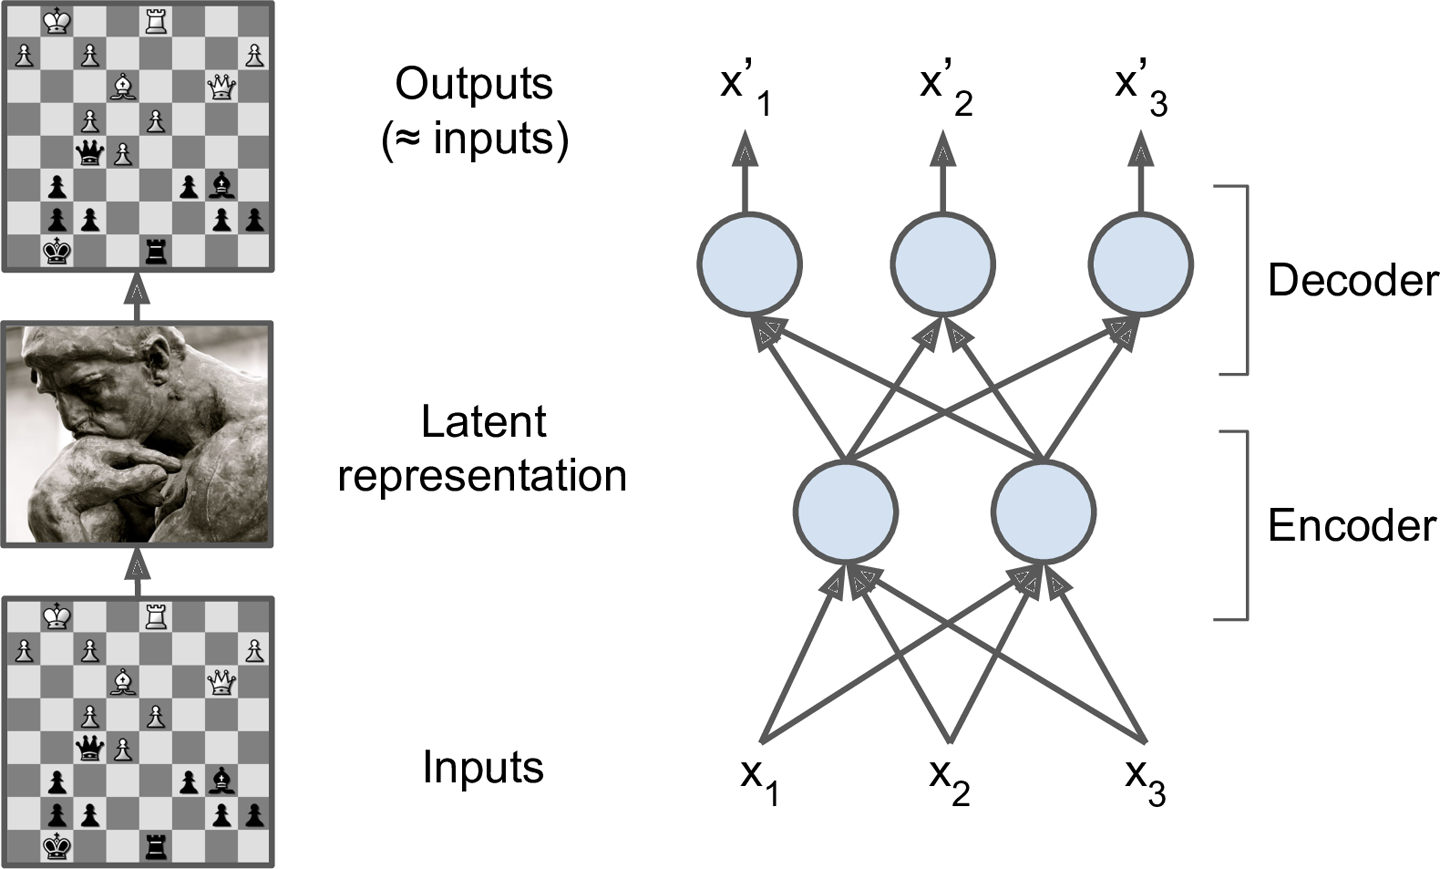
</div>

Same structure as MLP - but number of neurons in the output layer must be equal to the number of inputs. The output is called the reconstruction and has a reconstruction loss which penalizes the model is reconstruction is different from the inputs. 

The internal representation has a lower dimensionality, hence the autoencoder is undercomplete - cannot copy its inputs to the encoding, but find a way to output the same inputs. Forced to learn the most important features. 


# Performing PCA with an undercomplete linear autoencoder


PCA - if the autoencoder uses only linear activations and cost function is MSE, then it ends up performing PCA.

In [2]:
# a simple linear autoencoder to perform PCA on 3D datasets

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

# No need for activation (all neurons are linear) and cost function is MSE


autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=0.1))

Metal device set to: Apple M1


In [3]:
# Generating a random 3D dataset

np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=20)
# X_train is used both as input and target
codings = encoder.predict(X_train)

Epoch 1/20


2021-08-30 07:54:04.667295: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 0s 29ms/step - loss: 0.3959
Epoch 2/20
2/2 [==============================] - 0s 11ms/step - loss: 0.3595
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3301
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3042
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2816
Epoch 6/20
2/2 [==============================] - 0s 12ms/step - loss: 0.2615
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2421
Epoch 8/20
2/2 [==============================] - 0s 11ms/step - loss: 0.2229
Epoch 9/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2051
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.1877
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.1715
Epoch 12/20
2/2 [==============================] - 0s 10ms/step - loss: 0.1550
Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.13

<div>
    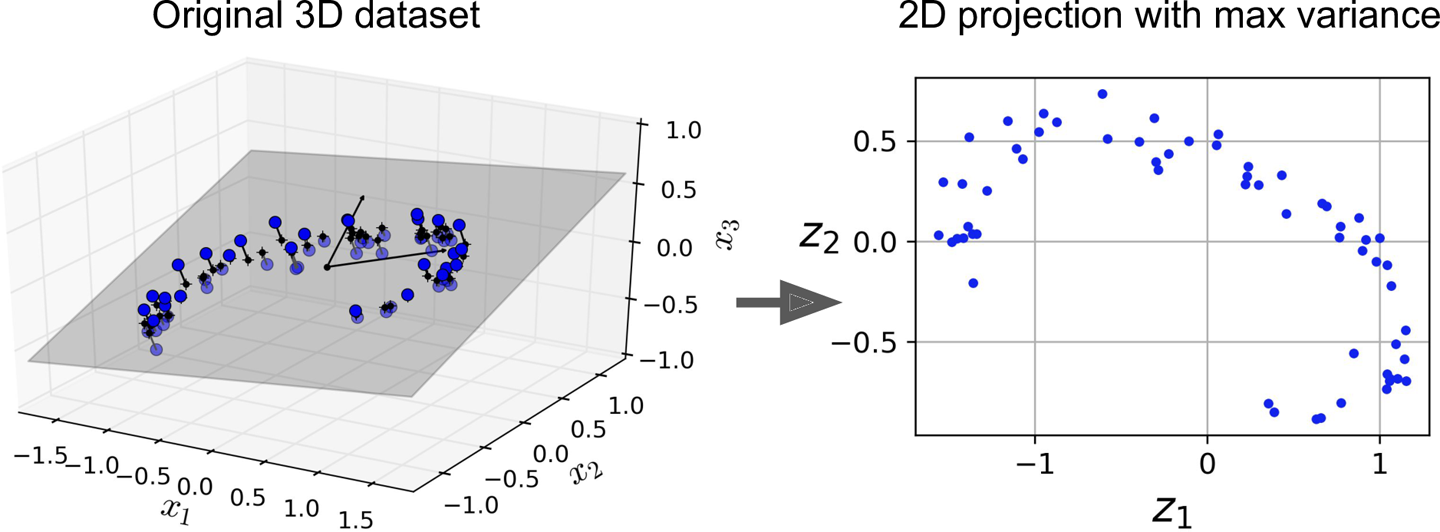
</div>



# Stacked Autoencoders

**Stacked (or deep) Autoencoders** - those with multiple hidden layers. More layers helps autoencoder learn more complex codings - be careful not to make it too powerful - it can just assign each input to a number and decode it - perfect reconstruction but not learned anything useful in the process.

Architecture is symmetrical and like sandwich:

Example is an autoencoder for the MNIST with 784 inputs


<div>
    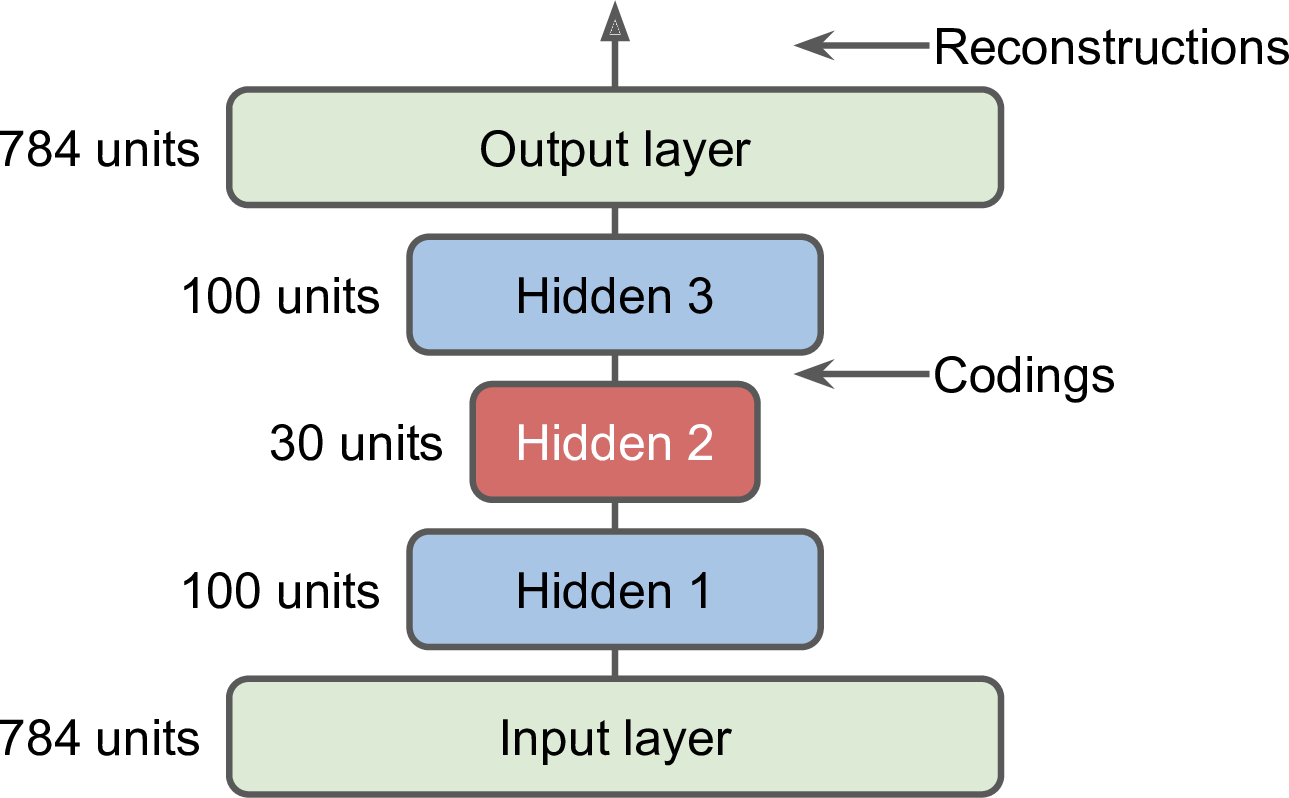
</div>

In [5]:
# Stacked Autoencoder with Fashion MNIST

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [6]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
    # can add the LeCun normal initilization but wont make much difference
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])


stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5))

# Using BCE as loss, treating reconstruction as a multilabel binary classification problem - makes convergence faster

history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.3374 - val_loss: 0.3120
Epoch 2/20
1719/1719 [==============================] - 25s 15ms/step - loss: 0.3058 - val_loss: 0.3036
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2994 - val_loss: 0.2980
Epoch 4/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.2954 - val_loss: 0.2950
Epoch 5/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2930 - val_loss: 0.2929
Epoch 6/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2912 - val_loss: 0.2943
Epoch 7/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.2898 - val_loss: 0.2902
Epoch 8/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.2888 - val_loss: 0.2893
Epoch 9/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.2879 - val_loss: 0.2915
Epoch 10/20
1719/1719 [==============================] - 25s 15m

## Visualising the Reconstructions - compare inputs with outputs


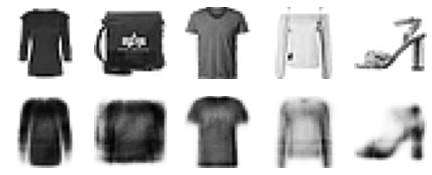

In [7]:

def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1+n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(stacked_ae)

# Recognisable but too lossy - need to train longer, or make encoder/decoder deeper
# But not make the network too powerful

## Visualising the Fashion MNIST

Now use the SAE to reduce dimensionality. Not as great results compared to other DR algorihtms, but one big advantage of SAE is to handle large datasets with many features/instances. One strategy is to use SAE first, than another DR algorithm for visualization. "

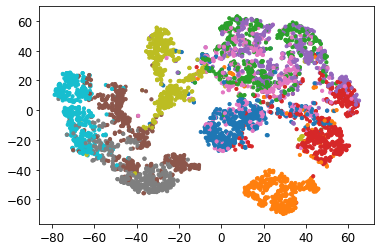

In [8]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)

tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')

## Unsupervised Pretraining

Other than DR, SAU can also be used for unsupervised pretraining.

For a complex supervised task without lots of lablelled data, one solution is to find a net that performs similar task and reuse lower layers - making it possible to train a high-performance model using little training data.

Therefore, with a large dataset that is mostly unlabelled, can first train a stacked autoencoder using all data, then reuse the lower layers to create a net for the actual task and train it with the lablled data. 


<div>
    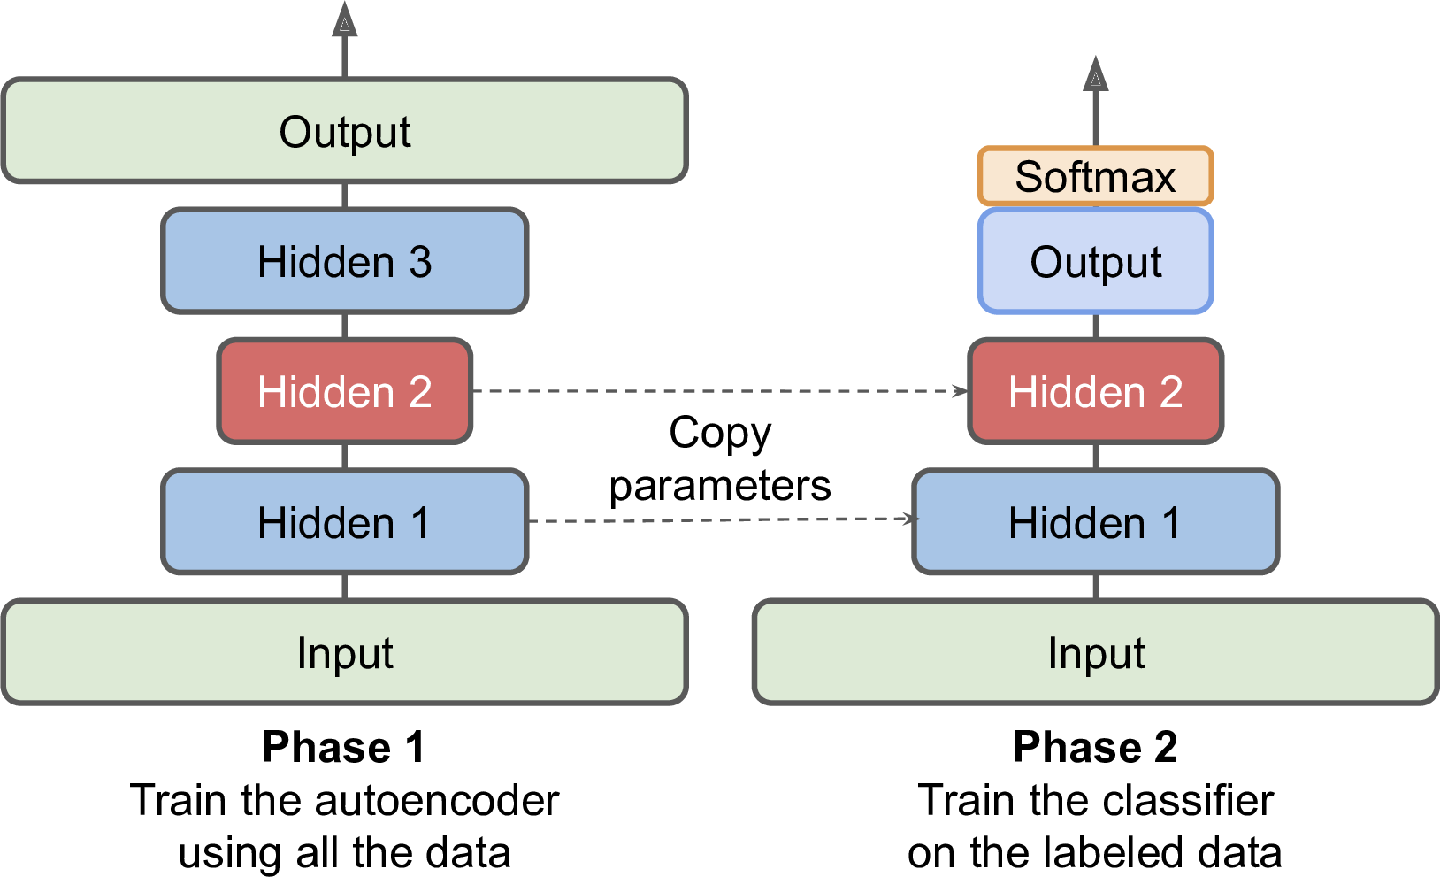
</div>

Simple implementation - just train autoencoder with the training data (both l and unlabelled), the reuse the encoder layers to create a new network.

## Tying Weights

For symmetrical autoencoder, a common technique is to tie the weights of decoder to the weights of encoder. This halves the number of weights, speeds up training and limits overfitting. 

In [9]:
class DenseTranspose(keras.layers.Layer):
    
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros",
                                      shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True) # multiplies the matrices
        return self.activation(z + self.biases)
    
    
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")


tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])


tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

## Training One Autoencoder at a time

Rather than training a stack, can also train 1 shallow autoencoder one at a time, then stack them later. Not used much nowadays, but good to know.

<div>
    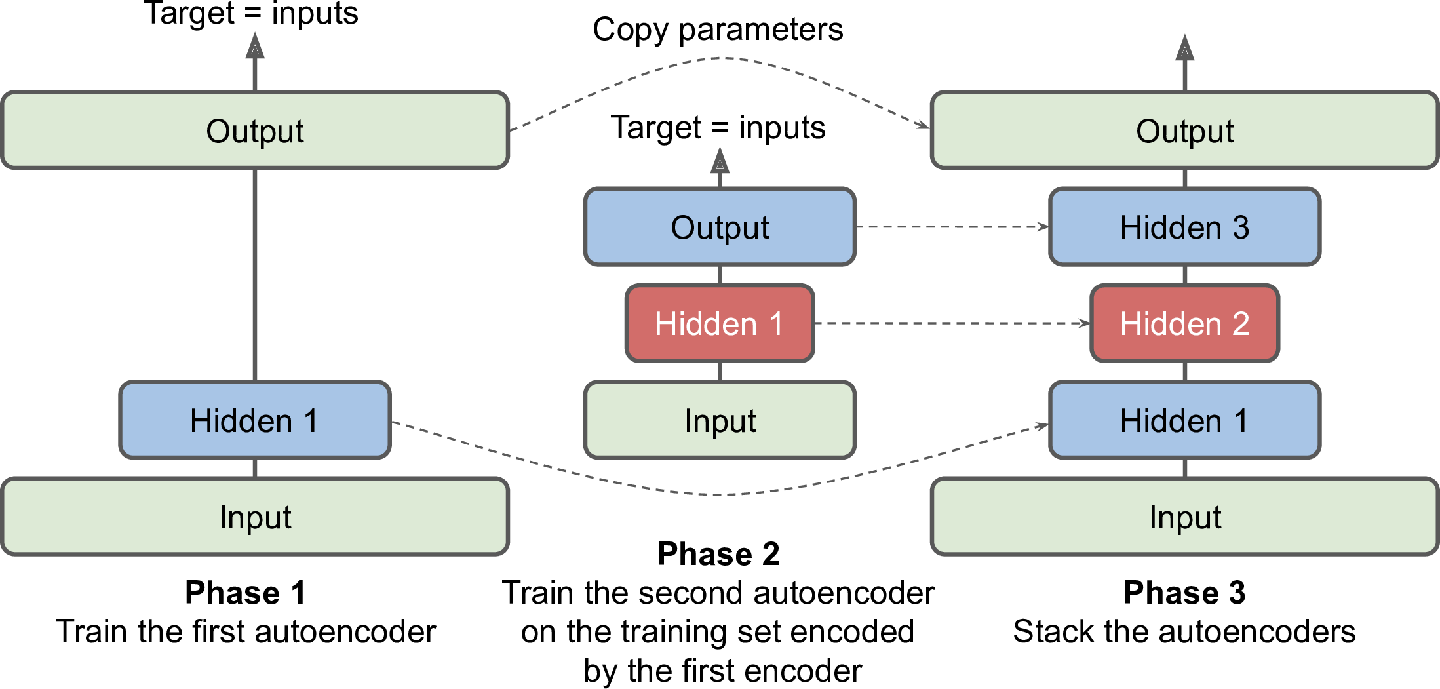
</div>


Again, when 2006 Hinton discovered that deep neural nets can be pretrained in an unsupervised way, it triggered a tsunami of interest in DL. This was using this greedy layerwise approach, but they used restricted Boltzmann machine. It was the only efficient way to train deep nets until the later techniques introduced in Chap11 made it possible to just train a deep net in one shot.

# Convolutional Autoencoders

A regular CNN composed of convolutional layers and pooling layers - reduces the dimensionality of the inputs while increasing the depth. Decoder does the reverse - upscale image and reduce depth back to original.

Can use transpose convolutional layers (or combine upsampling layers with convolutional layers):

In [10]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])


conv_decoder = keras.models.Sequential([
    #Transpose is a transposed convolutional layer, i.e. deconvolutional layer reversing its effect
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID",
                                 activation="selu", input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])



# Recurrent Autoencoders

RNNs, according to Chap 15 (skipped for irrelevence), are best for sequences such as time series or text.

Simple - sequence-to-vector RNN compressing the input sequence into a single vector

In [11]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

# Can process sequences of any length with 28 dimensions per step, hence can actually process the Fashion MNIST

# Denoising Autoencoders

**Constraint 1**


Adding noise to the inputs, training it to recover the original, noise-free inputs. Can be Gaussia. noise, or randomly switched-off inputs like in dropout.

<div>
    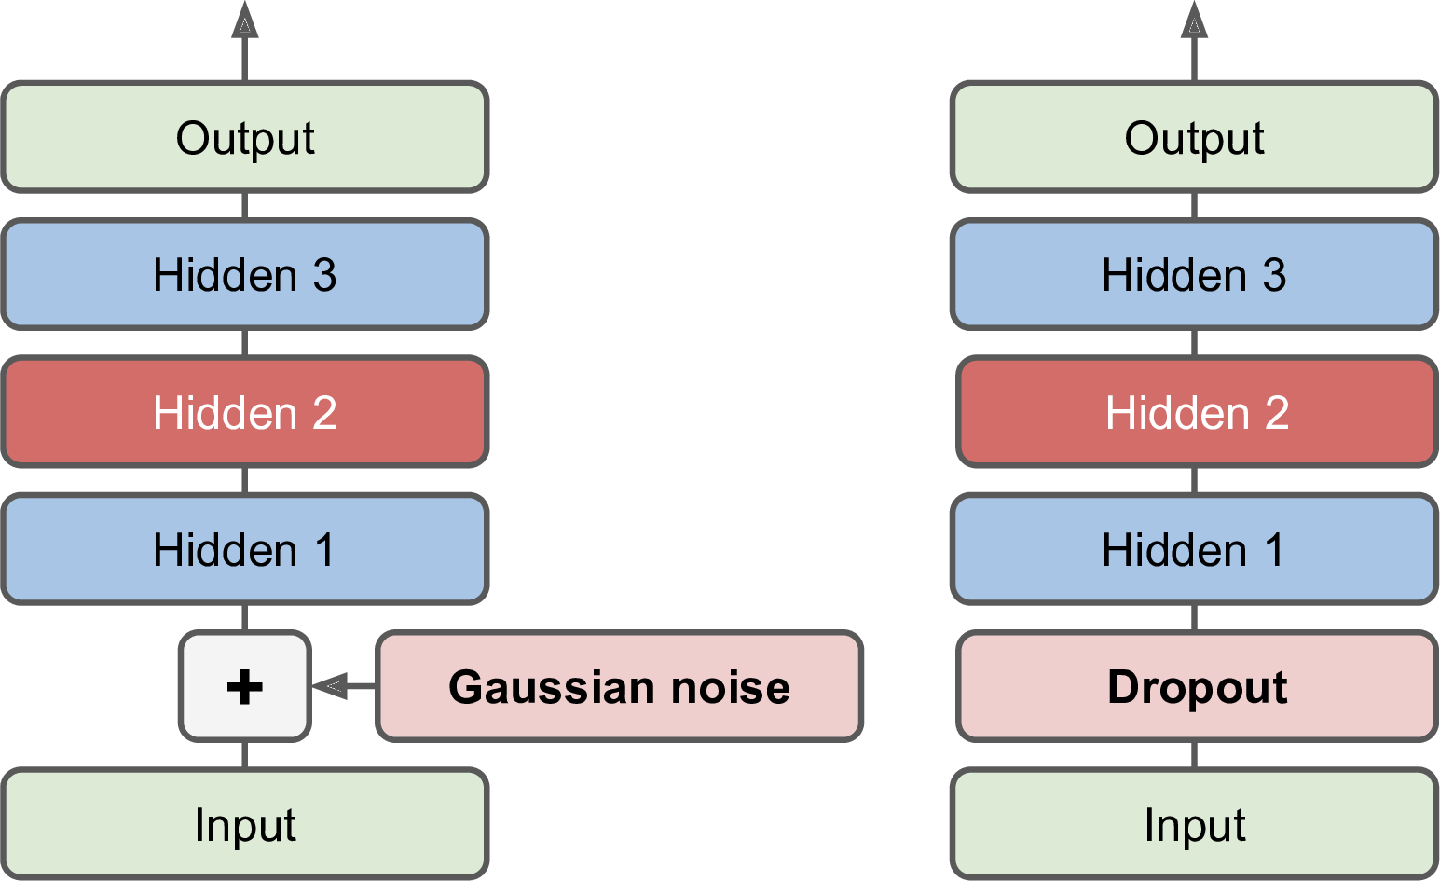
</div>

Straightforward - regular SAE with an additional dropout - or Gaussian - but both only active during training:

In [21]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [22]:
tf.random.set_seed(24)
np.random.seed(24)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

In [23]:

dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])

history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data = (X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3545 - rounded_accuracy: 0.8724 - val_loss: 0.3237 - val_rounded_accuracy: 0.9034
Epoch 2/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.3185 - rounded_accuracy: 0.9026 - val_loss: 0.3116 - val_rounded_accuracy: 0.9098
Epoch 3/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.3127 - rounded_accuracy: 0.9072 - val_loss: 0.3138 - val_rounded_accuracy: 0.9099
Epoch 4/10
1719/1719 [==============================] - 30s 18ms/step - loss: 0.3093 - rounded_accuracy: 0.9100 - val_loss: 0.3047 - val_rounded_accuracy: 0.9156
Epoch 5/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3069 - rounded_accuracy: 0.9119 - val_loss: 0.3025 - val_rounded_accuracy: 0.9184
Epoch 6/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3051 - rounded_accuracy: 0.9133 - val_loss: 0.3021 - val_rounded_accuracy: 0.9161
Epoch 7/10
1719/1719 [======

In [40]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'predict'

# Sparse Autoencoders

Another constraint is sparsity.

Adding appropirate term to the cost function, pushing the AE to reduce the number of active neurons in the coding layer. May be pushed to have an average of 5% significantly active neuron in the coding, forcing the AE to represent each input as a combination of activations. Therefore each neuron ends up representing a useful feature. 

Can use sigmoid in the coding layer, use a large coding layer and using L1 regularization.

In [24]:
# L1 regularizer

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)
    # Returns inputs but adds a training loss equal to the inputs' absolute values
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28),
    keras.layers.Reshape([28, 28])
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [28]:
# Sparse autoencoder based on the KL divergence

# First creating a custom regularizer to apply KL divergence regularization

K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
        
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities))

In [30]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])

history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.4148 - rounded_accuracy: 0.8122 - val_loss: 0.3692 - val_rounded_accuracy: 0.8619
Epoch 2/10
1719/1719 [==============================] - 37s 21ms/step - loss: 0.3515 - rounded_accuracy: 0.8782 - val_loss: 0.3428 - val_rounded_accuracy: 0.8850
Epoch 3/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3341 - rounded_accuracy: 0.8913 - val_loss: 0.3314 - val_rounded_accuracy: 0.8955
Epoch 4/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3238 - rounded_accuracy: 0.9005 - val_loss: 0.3219 - val_rounded_accuracy: 0.9040
Epoch 5/10
1719/1719 [==============================] - 38s 22ms/step - loss: 0.3173 - rounded_accuracy: 0.9057 - val_loss: 0.3174 - val_rounded_accuracy: 0.9069
Epoch 6/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3137 - rounded_accuracy: 0.9089 - val_loss: 0.3142 - val_rounded_accuracy: 0.9093
Epoch 7/10
1719/1719 [======

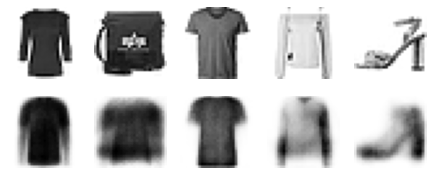

In [32]:
show_reconstructions(sparse_kl_ae)

In [36]:
# Copied to make pretty diagrams
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)
    
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

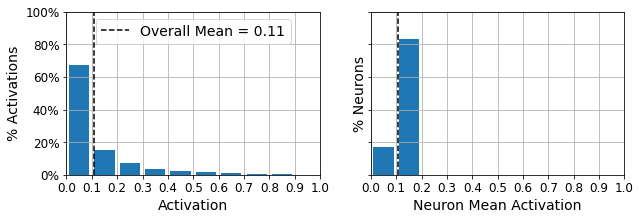

In [37]:
# Activation of neurons are mostly close to 0, and all have a mean activation around 0.1 (90% between 1 and 2)
plot_activations_histogram(sparse_kl_encoder)
plt.show()

# Variational Autoencoders

2013 - by Kingma and Welling, one of the most popular nowadays.

Diff cause:
- Probabilistic autoencoders - their output are determined by chance, even after training (where denoising autoencoders, eg. use randomness only during training)
- Generative autoencoders - generate new instances that look like they were sampled from the training set

These features make them similar to RBMs, but they are easier to train and sampling is much faster. They perform variational Bayesian inference - efficient to perform approximate Bayesian inference. 


As shown, same to before have 2 hidden layers for encoding and decoding. However, instead of ust producing a coding for an input, they also produce a mean coding μ and standard deviation σ. 

Actual coding is sampled randomly from a Gaussian distribution with mean μ and deviation σ. 


1. Encoder produces μ and σ
2. Coding sampled randomly within the range
3. Then coding is decoded


<div>
    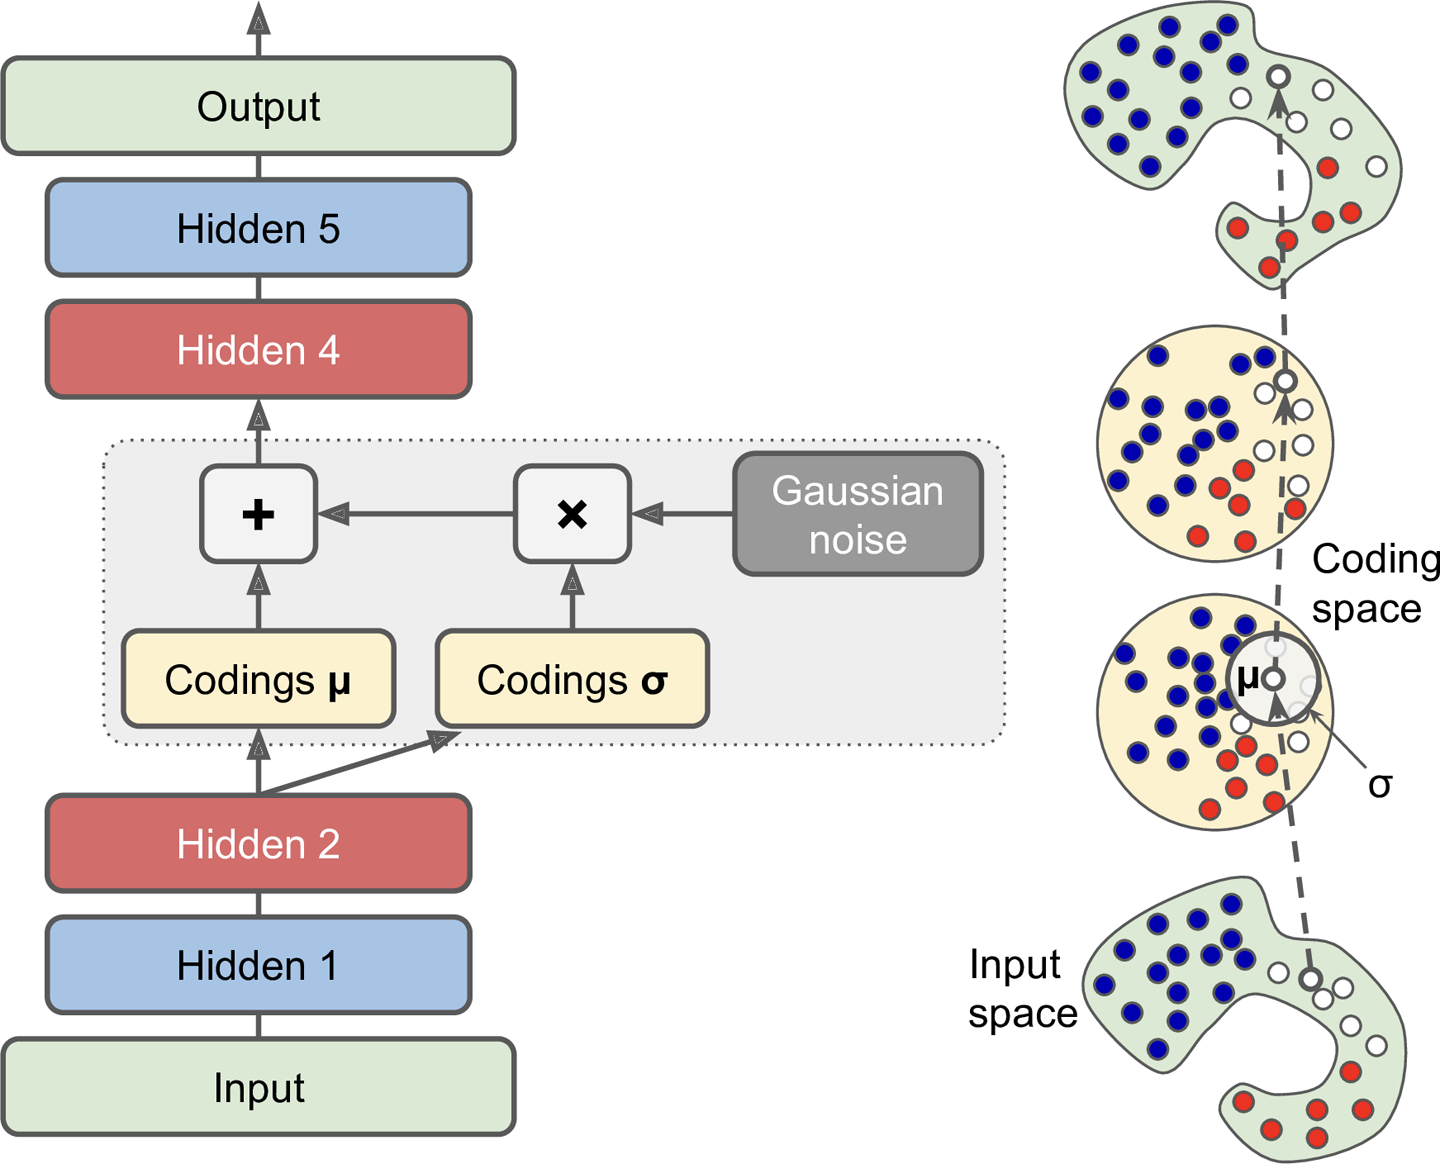
</div>


Despite how convoluted distribution is, output is good. One advantage is after training a variaitonal autoencoder, can easily generate a new instance - just sample random coding, and decode it, voila!


### Cost Function

2 parts:
1. Usual reconstruction loss pushing the VAE to produce inputs
2. Latent loss - pushing the VAE to have codings that look as though they were sampled from a random Gaussian distribution: the KL divergence between target distribution and actual distribution. 

In [31]:
# To sample the codings given μ and γ
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
# Takes two inputs μ and γ, and uses random_normal() to sample a random vector (γ/2 = σ)

In [41]:
# Using Keras Functional API

codings_size = 10

# Encoder
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

codings_mean = keras.layers.Dense(codings_size)(z) # μ
codings_log_var = keras.layers.Dense(codings_size)(z) # γ
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])


# Decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)

outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])


# VAE
_, _, codings = variational_encoder(inputs) # Ignore first 2 outputs - only want the codings
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])


# Adding the Latent and Reconstruction losses
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.) # To ensure scale is the same
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

In [43]:
history = variational_ae.fit(X_train, X_train, epochs=20,
                             validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 57s 33ms/step - loss: 0.3354 - val_loss: 0.3309
Epoch 2/20
1719/1719 [==============================] - 53s 31ms/step - loss: 0.3244 - val_loss: 0.3274
Epoch 3/20
1719/1719 [==============================] - 60s 35ms/step - loss: 0.3205 - val_loss: 0.3222
Epoch 4/20
1719/1719 [==============================] - 59s 34ms/step - loss: 0.3182 - val_loss: 0.3196
Epoch 5/20
1719/1719 [==============================] - 56s 33ms/step - loss: 0.3168 - val_loss: 0.3192
Epoch 6/20
1719/1719 [==============================] - 54s 32ms/step - loss: 0.3157 - val_loss: 0.3170
Epoch 7/20
1719/1719 [==============================] - 53s 31ms/step - loss: 0.3149 - val_loss: 0.3156
Epoch 8/20
1719/1719 [==============================] - 52s 30ms/step - loss: 0.3143 - val_loss: 0.3160
Epoch 9/20
1719/1719 [==============================] - 51s 29ms/step - loss: 0.3137 - val_loss: 0.3155
Epoch 10/20
1719/1719 [==============================] - 51s 30m

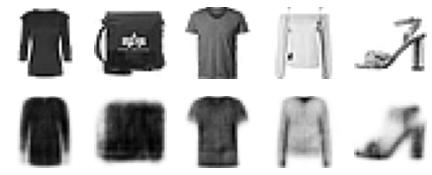

In [44]:
show_reconstructions(variational_ae)

## Generating Fashion MNIST Images

Images that look like fashion items. Sample random codings from a Gaussian distribution and decode:

In [45]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

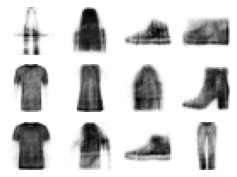

In [46]:
tf.random.set_seed(24)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

Fairly convincing, but too fuzzy! 

**Semantic Interpolation** (some estimation) - instead of interpolating 2 images at the pixel level, we can interpolate at the codings level. Run both images through the encoder, interpolate both bodings, and then decode the interpolated codings to get the final image. 

Will look like a regular Fashion MNIST image, but intermediate between the original images. 

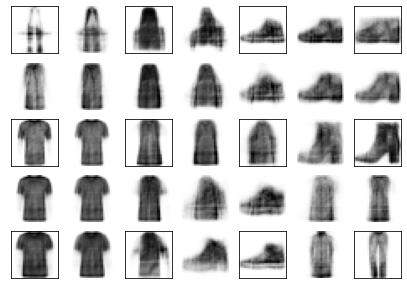

In [47]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])

interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

# Generative Adversarial Networks

2014, by Ian Goodfellow, but took a few years to overcome some training diffculties. Simple in hindset - make neurla networks compete against each other in the hope that competition pushes them to excel. 

*Generator* - takes a random distribution as input (Gaussian, usually), and outputs some data - typically an image. Think of the random inputs as the latent representations (codings) of the images to be generated. Offers same functionality as a decoder in a VAE, and can be used in the same way to generate new images (just feed Gaussian noise and it will output a brand-new image). But it's trained very differently.


*Discriminator* - takes either a fake image from the generator or a real image from the training set as input, and must guess whether it's fake or real. 

<div>
    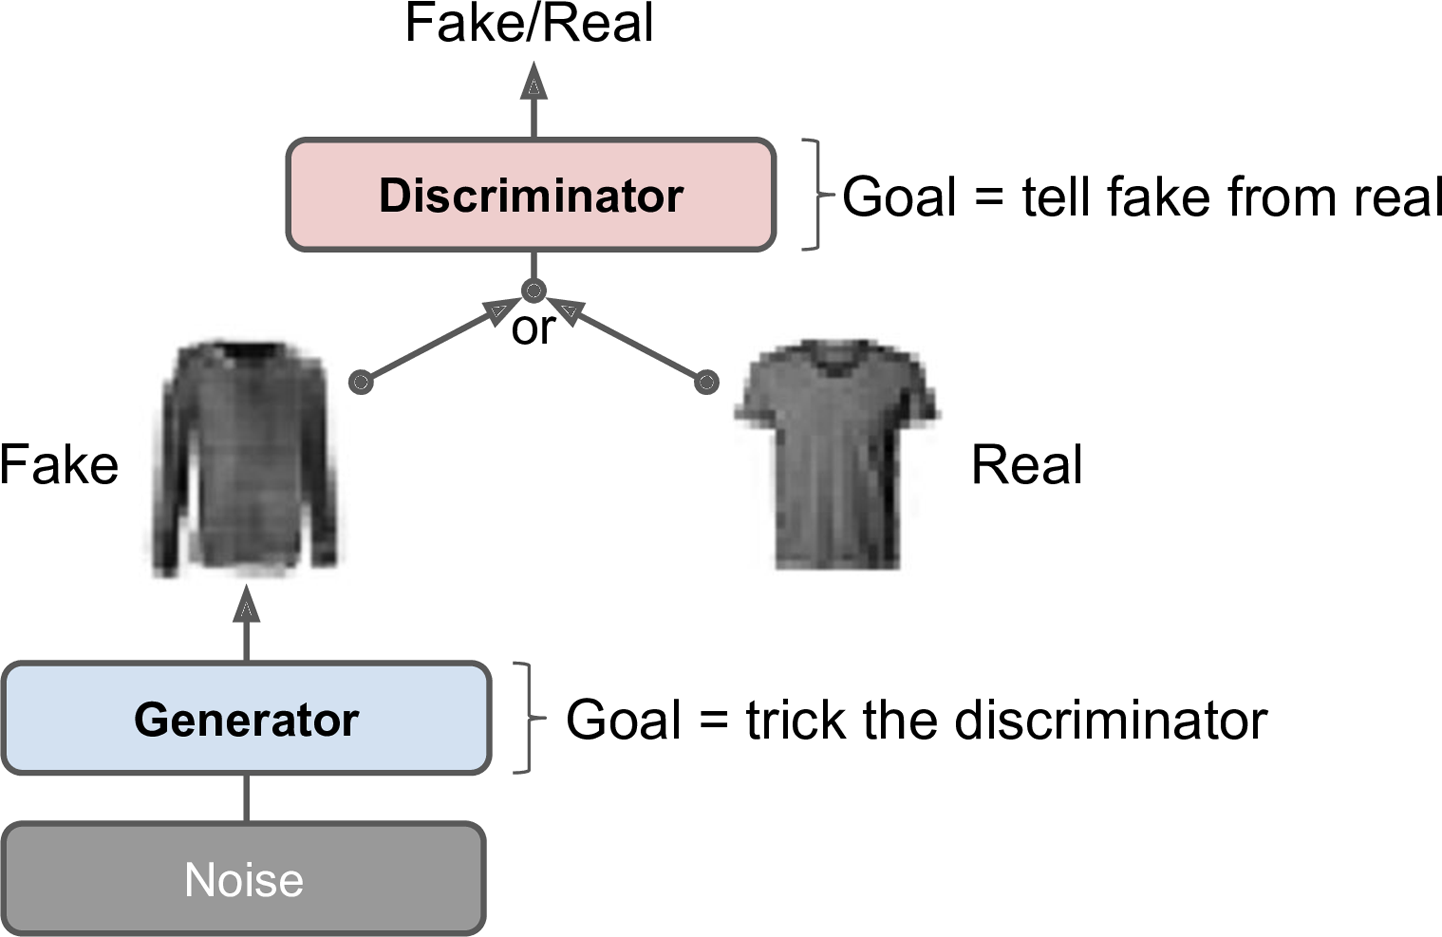
</div>


During training, discriminator tries to tell fake from real images, while the generator tries to produce images that look real enough to trick the discriminator. Cannot be trained like a regular neural net, each iteration is divided into 2 phases:
1. Discriminator - batch of real images sampled from the training set and completed with an equal number of fake images produced by the generator. Labels set to 0 for fake and 1 for real - discriminator trained on this labeled batch for 1 step, using the binary cross-entropy loss. **Backpropagation only optimizes the weights of the discriminator during this phase**
2. Generator - first to produce another batch of fake images, and the discriminator is used to tell whether they are fake or real. This time do not add real images, and all are set to 1 - we want the generator to produce images that the discriminator will believe to be real! **Weights of the discriminator are frozen, so backpropagation only affects weights of the generator**. 


The generator never sees real images, but will learn to produce convincing fake images! It has the gradients flowing back through the discriminaotr. Which means, better the discriminator, more information about the real images is contained in these secondhand gradients. 

In [48]:
codings_size = 30

# Generator - similar to decoder
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# Discriminator - regular binary classifier
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [50]:
# As discriminator is a binary classifier we can use the binary cross entropy loss
# Generator only trained through the GAN model, no no need to compile. 
# Discriminator should not be trained during the 2nd phase - we make it non-trainable before compiling


discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
# Discriminator is trainable if we call fit() or train_on_batch(), but not during GAN training

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")


In [ ]:
# Have to write a custom training loop


batch_size = 32

# Dataset first:

# Creates a dataset whose elements are slices for the given tensor
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
# Combines elements into batches
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [54]:

# Training Loop
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()


Phase 1 - we feed the Gaussian noise to the generator to produce fake images, and complete the batch by concatenating an equal number of real images. y1 = 0 for fake, 1 for real. Then we train the discriminator on this batch - trianable becomes true.

Phase 2 - feed the GAN some Gaussian noise. Generator will start producing fake images, and discriminator will guess whether they are fake or real. We want the discriminator to believe that fake images are real, so y2 are set to all 1. Trainable becomes false to avoid a warning.  

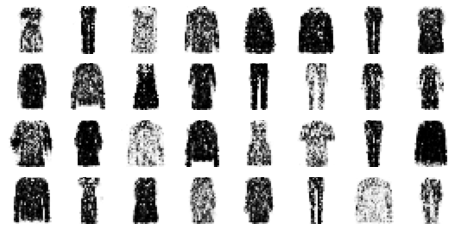

In [55]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

## Difficulties of Training GANs

Above is the result of the first epoch, but after this GANs do not get better and sometimes even forget past content. Why?

During training, both generator and discriminator try to outsmart each other, and may end up in a state called a **Nash equilibrium** - when no player would be better off changing their strategy, assuming the other does not change theirs. EG. when everyone drives to the left - no driver is better off by going right. Or, everyone drives to the right. Different initial states/dynamics lead to different outcomes.

In this case there is a single optimal strategy once an equilibrium is reached - in which case changing to one of the other possible competing strategies does not help.

For GANs, paper showed that it can only reach one Nash Equilibrium - where the generator produces perfectly realistic images, and the discriminator is forced to guess (50,50). If you train long enough, the generator will be almost perfect - sounds good. Nevertheless, no guarantee that the equilibrium can be ever reached. 


**Node Collapse** - when the generator's outputs become less diverse. Suppose the generator gets better at producing convincing shoes than any other class, it will fool the discriminator with shoes and continue to produce shoes. It will also forget about everything else, and equally the discriminator will forget to distinguish objects of other classes. When discriminaotr eventually becomes good at shoes, the generator will switch to something else and completely forget about shoes. It may just cycle across a few classes and never becoming too good at any. 

ALso instabilities - oscillating/unstable parameters - diverge for no apparent reason. Many factors affect these dynamics - GANs are very sensitive to hyperparameters - should spend a lot of effort fine-tuning them. 


Possible Solution:

**Experience Replay** - by good researchers - storing the images produced by generator at each iteration in a replay buffer (gradually dropping older ones) and training the discriminator using real+fake images drawn from this buffer (rather than the current fake images). Reduces the chances of overfitting to the latest generator's outputs. 

**Mini-batch Discrimination** - measuring how similar images are across the batch and provide the statistics to the discriminator - so can reject a whole bath of fake images lacking diversity. Encouraging the generator to produce a greater vareity of images.


Excellent/new/active field - lots of new progress!

## Deep Convolutional GANs

Late 2015 - deep convolutional GANs - CDGANs:
- Replace pooling layers with strided convolutions (in discriminator) and transposed convolutions (generator)
- Use Batch Normalization in both generator and discriminator, except in the generator's output and discriminator's input layers
- Remove fully connected hidden layers for deeper architectures
- Use RELU in generator for all except output layer, whcih uses tanh
- Leaky ReLU activation in the discriminator for all layers

Still explore with many hyperparameters - sometimes changing the random seed and training the same model again might work:

In [71]:
# One example for fashion MNIST

tf.random.set_seed(42)
np.random.seed(42)


codings_size = 100
# Takes codings of 100, projects to 7*7*128 dimensions, then reshapes to get a 7*7*128 tensor

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    # Upsamples from 7*7 to 14*14 and reduces its depth from 128 to 64
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    # Upsamples from 14*14 to 28*28 and reduces depth from 64 to 1 - tanh output is -1~1
    # for this reason, before training need to rescale the training set to the same range
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh")
])

# Looks like a regular CNN for binary classification

# Instead of using max pooling to downsample, we used strided convolutions
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [76]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [77]:
# Same code as earlier

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [78]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [79]:
# Same code as earlier
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

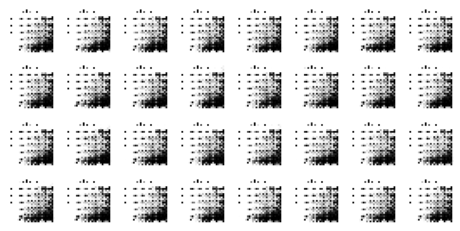

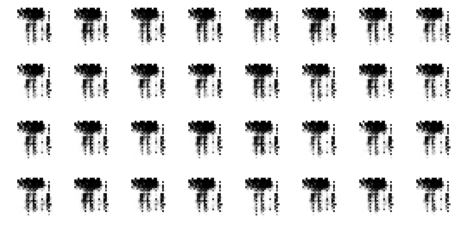

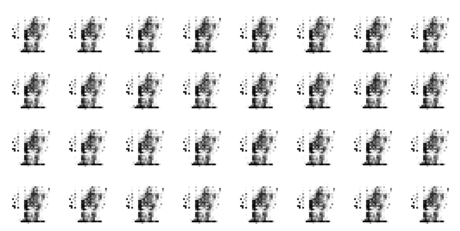

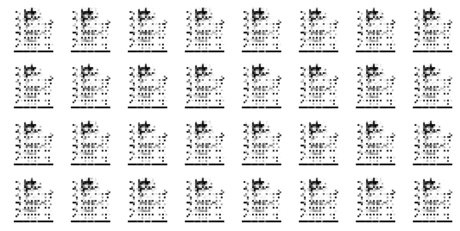

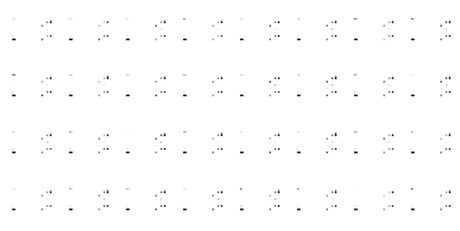

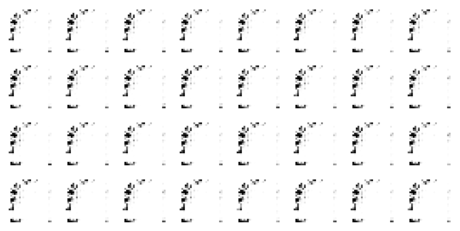

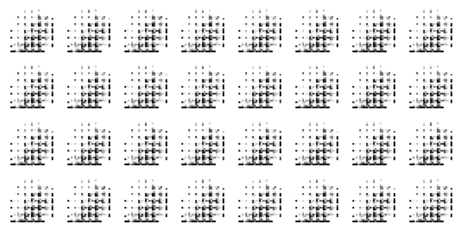

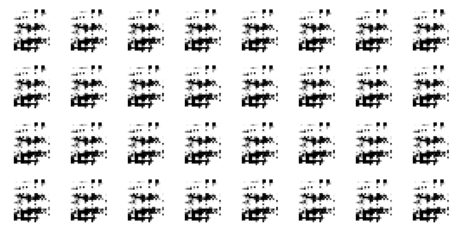

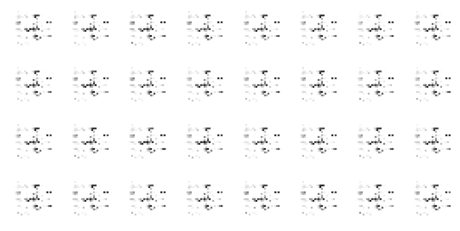

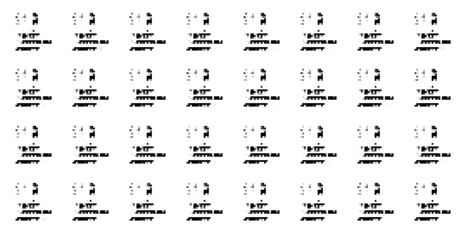

In [80]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs = 10)

If scaled up and trained on a large dataset of faces, get fairly realistic images. 

The lower ones are latent space averages of the 3 above - hence still realistic. 


<div>
    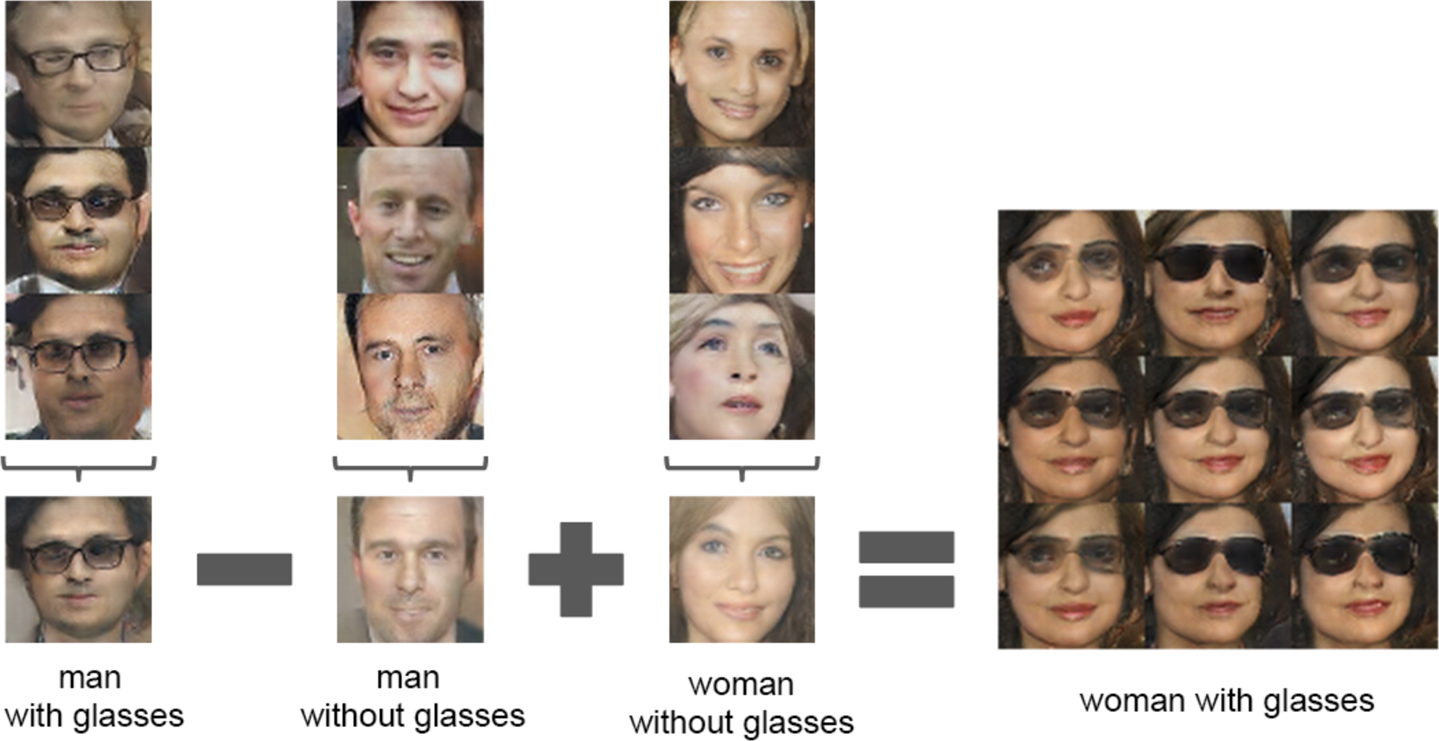
</div>

## Progressive Growing of GANs

2018 important technique by Tero Karras - generating small images at the beginning, then gradually add convolutional layers ot both generator and discriminator to produce larger and larger images. This resembles greedy layer-wise training of stacked autoencoders. 


Extra layers are added ta the end of generator and beginning o discriminator, and only previously trained layers are trainable. 


Essentially - the new convolutional layers (dashed lines) are gradually faded in, while the original output layer is gradually faded out. A similar fade-in/fade-out technique is used when a new convolutional layer is added to the discriminator. (followed by an average pooling for downsampling).


<div>
    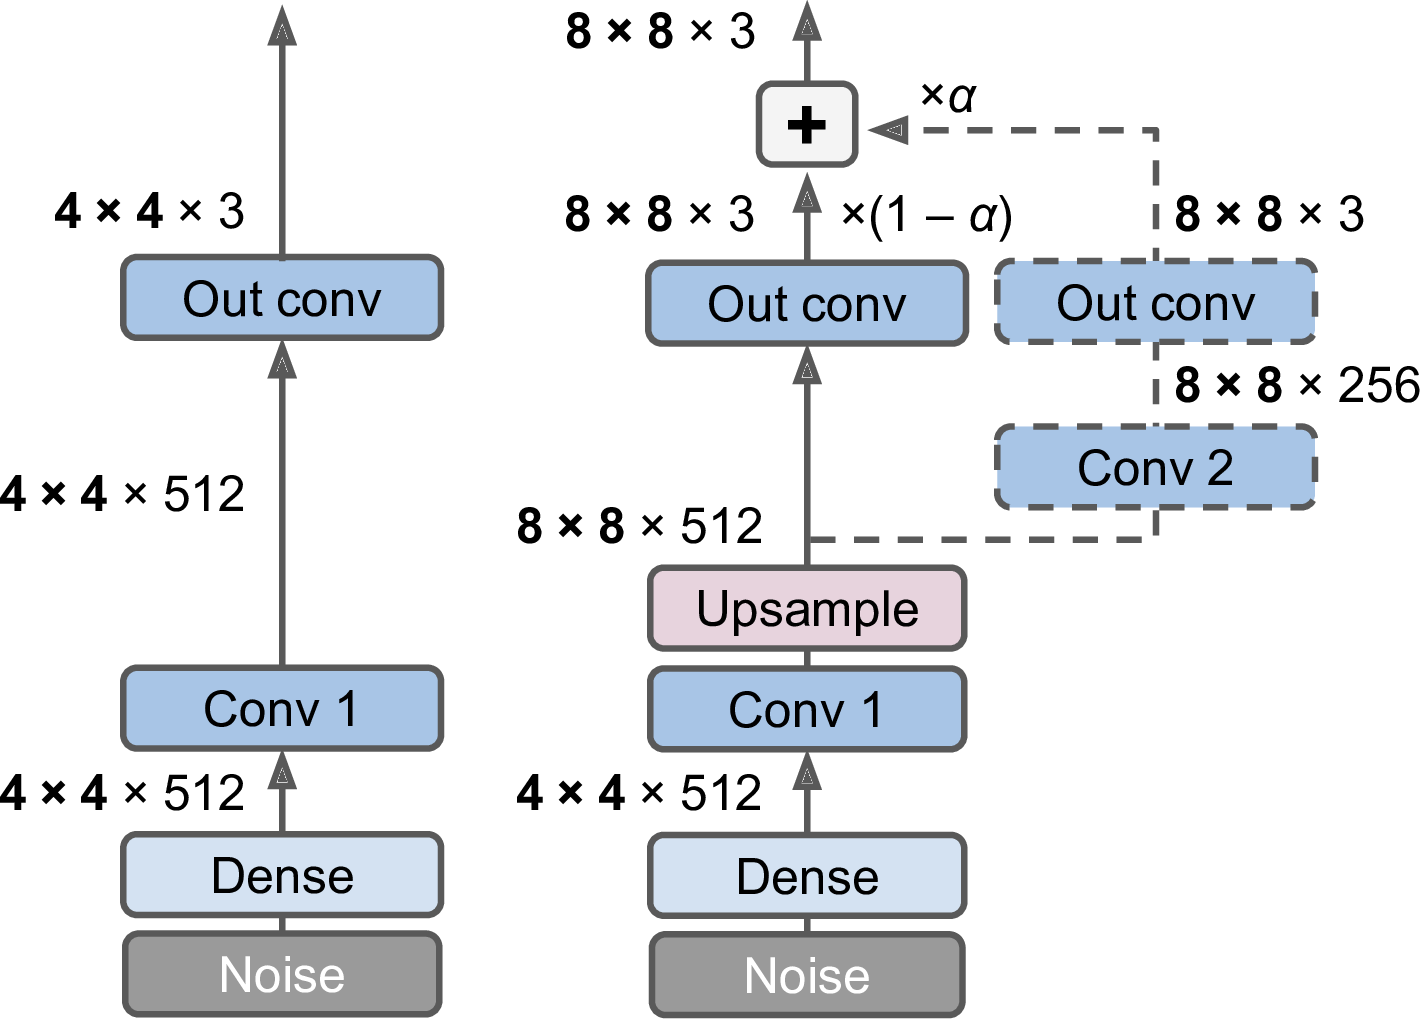
</div>


Several other techniques aimed at increasing the diversity of outputs:

**Minibatch standard deviation layer**: 
- Added near end of discriminator
- computes SD across all channels/all instances in the batch. Then averaged across all points to get a single value. 
- extra feature map added to each instance in the batch and filled with computed value.
- Why it works: if generator produces images with little variety, then there will be smaller SD across feature maps in the discriminator. GIving discriminator this stats encourages the generator to produce more diverse outputs.

**Equalized learning rate**:
- Initialize all weights with Gaussian distribution with mean 0 and SD 1 rather than using He initilization.
- weights are sclaed down at runtime by the same factor as He initialization
- Significantly improves GAN's performance when using RMSProp, Adam or other gradient optimziers. These optimizers normalize the gradient updates by their estimated standard deviation, so parameters that have a larger dynamic range will take longer to train. 
- By rescaling weights in model rather than upon initialization, ensures the dynamic range is same for all parameters throghout training. So they all learn at the same speed - speeds up and stabilizes training.

**Pixelwise normalization layer**:
- added after each convolutional layer in generator.
- normalizes each activation based on all activations in the same image at same location, but across all channels. 
- avoids explosions in the activations due to excessive competition between generator and discriminator.


These techniques made extremely convincing high-definition images of faces. Still, evaluation is challenging working with GANs - although its possible to evaluate diversity of generated images, judging their quality is much trickier. One technique is to use human raters, but expensive. So author proposed measuring the similarity between local image structures of the generated images and the training images, considering every scale. 

This led to StyleGANs. 

## StyleGANs

2018 by Nvidia team - using style transfer techniques in the gerenator to ensure generated images have the same local strucutre as the training images, at every scale, to improve the quality of generated images.

Discriminator and the loss function were not modified, only the generator. StyleGAN is composed of 2 networks:

*Mapping Network*:
- 8 layer MLP, maping the latent representation z (codings) to a vector w. Vecotr is then sent through multiple affine transformations (Dense layers with no activation functions, represented by the "A" boxes), producing multiple vecotrs.
- Vectors control the style of generated images at different levels - fine-grained texture to high-level features.
- Mapping network maps the codings to multiple style vectors


**Synthesis network**:
- Generating the image.
- Constant learned input (constant after training, but gets tweaked by backpropagation during training) - processes this input through multiple convolutional and upsampling layers.
- Twists: 1. some noise added to the input and all the outputs of conv layers.
- 2. each noise followed by an Adaptive Instance Normalization layer - standardizes each feature map indepedently (by subtracting feature map's mean and diving by its standard deviation). Then uses the style vector to determine the scale and offset of each feature map.

<div>
    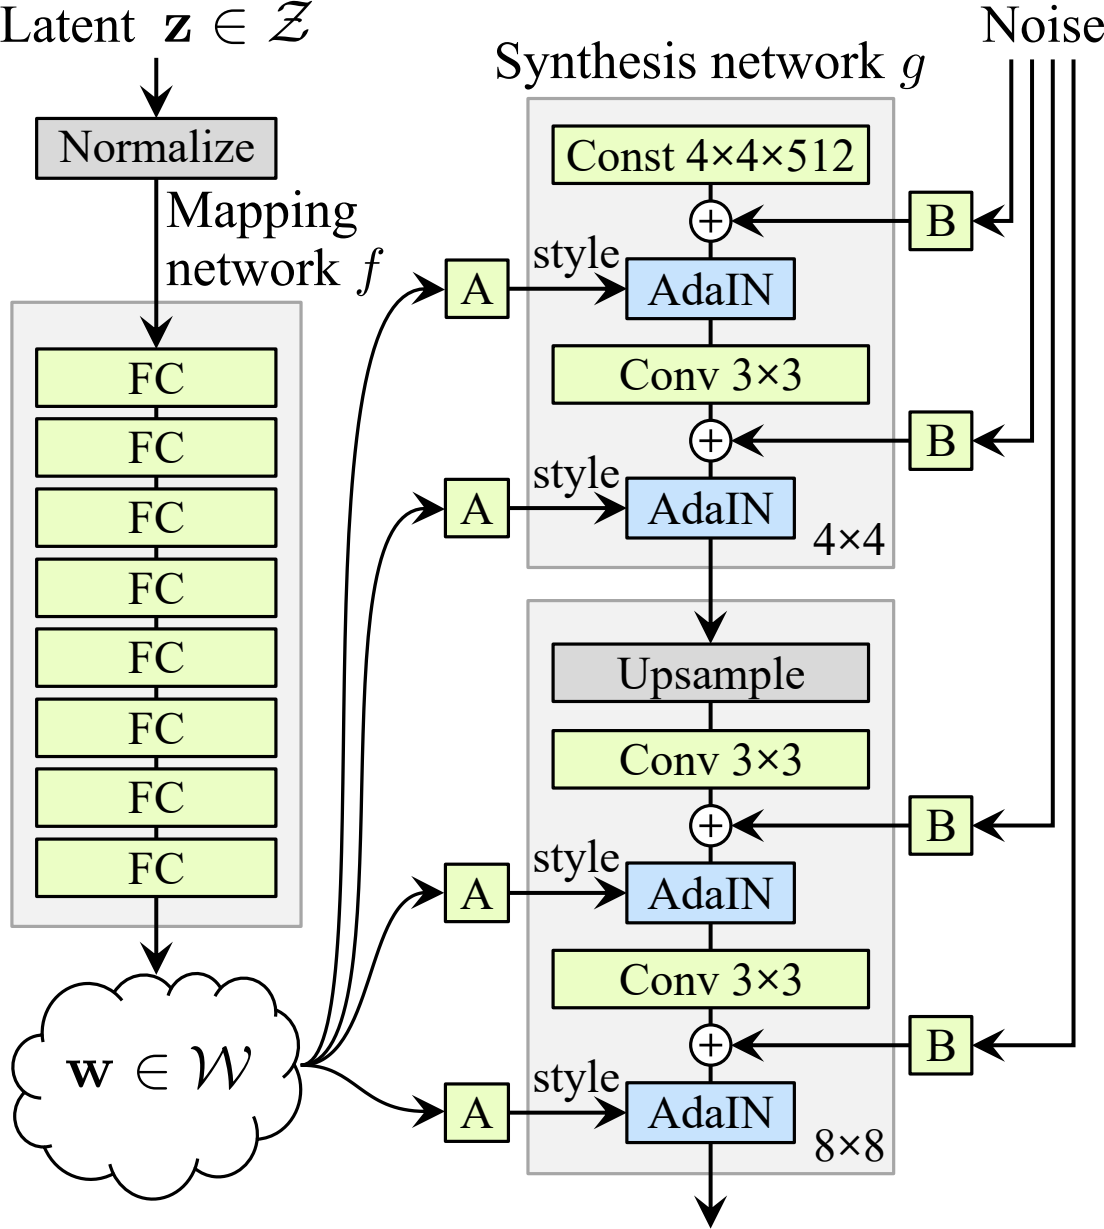
</div>

Idea of adding noise independently drom codings is very important. 

Some parts of image are random (exact positions of freckle or hair), and in earlier GANs, this randomness had  to come from codings or some pseudorandom noise produced by the generator. It was quite wasteful, slowed down training, and at times was not convincing. By adding extra noise inputs, all the issues are avoided. The GAN can now add the right amount of stochasticity to each part of the image. 


Padded noise is different at each level - each noise contains a single feature map full of Gaussian noise broadcasted to all feature maps and scaled.


**Mixing Regularization** (style mixing): another StyleGAN technique where a % of generated images are produced using 2 different codings. The codings c1 and c2 are sent through to produce style vectors w1 and w2, then the synthesis network generates an image based on styles w1 for the first levels and w2 for the remaining levels. Cutoff is selected randomly. This prevents the network from assuming styles at adjacent levels are correlated, in turn encouraging locality in the GAN, and each style vector only affects a limited number of traits in the generated image. 


Huge variety of GANs. This is introduction giving desire to learn more.

Also, its normal for GANs to have trouble learning at first - requires a bit of patience before it works, but the result is worth it. Plenty of Keras or TF implementations to look at beforehand. If want to get amazing results quickly, can just use a pretrained model (like StyleGAN models).

